# Несбалансированные выборки. Практическая работа

## Цель практической работы

Научиться обрабатывать несбалансированные данные и обучать модели машинного обучения на таких данных.

## Что входит в работу


1. Загрузить данные и провести разведочный анализ.
2. Разделить данные на обучающую и тестовую выборки.
3. Подготовить данные для моделирования.
4. Сбалансировать данные методом SMOTE и обучить модель машинного обучения.
5. Обучить модель машинного обучения с использованием весов классов и кросс-валидации.
6. Сравнить метрики качества четырёх моделей.




## Что оценивается 

- Выполнены все этапы работы.
- Не допущена утечка данных при разделении выборок и подготовке данных.
- Данные корректным образом сбалансированы.
- Модели не переобучены.


## Как отправить работу на проверку

Скачайте файл с заданиями в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.


# Задача

Пусть у нас имеется некоторый набор данных `german_credit_data.csv` о заёмщиках банка:

* Age — возраст заёмщика.
* Sex — пол заёмщика.
* Job — тип работы заёмщика.
* Housing — тип жилья заёмщика.
* Saving accounts — объём средств на сберегательных счетах заёмщика.
* Checking account — объём средств на основном счёте заёмщика.
* Credit amount — размер кредита. 
* Duration — срок кредита (в месяцах).
* Purpose — цель кредита.
* Risk — таргет, допустил ли заёмщик просрочку платежей по кредиту.

Решите задачу классификации заёмщиков, чтобы банк умел заранее предсказывать просрочку платежей по кредиту. 



# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

In [40]:
help('sklearn.preprocessing.OrdinalEncoder')

Help on class OrdinalEncoder in sklearn.preprocessing:

sklearn.preprocessing.OrdinalEncoder = class OrdinalEncoder(_BaseEncoder)
 |  sklearn.preprocessing.OrdinalEncoder(*, categories='auto', dtype=<class 'numpy.float64'>, handle_unknown='error', unknown_value=None)
 |  
 |  Encode categorical features as an integer array.
 |  
 |  The input to this transformer should be an array-like of integers or
 |  strings, denoting the values taken on by categorical (discrete) features.
 |  The features are converted to ordinal integers. This results in
 |  a single column of integers (0 to n_categories - 1) per feature.
 |  
 |  Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
 |  
 |  .. versionadded:: 0.20
 |  
 |  Parameters
 |  ----------
 |  categories : 'auto' or a list of array-like, default='auto'
 |      Categories (unique values) per feature:
 |  
 |      - 'auto' : Determine categories automatically from the training data.
 |      - list : ``categories[i]`` ho

In [6]:
# Загрузим датасет
df = pd.read_csv('german_credit_data.csv')
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [17]:
# Посмотрим на характеристики датасета
df.describe(include='all')

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
count,1000.000000,1000,1000.000000,1000,817,606,1000.000000,1000.000000,1000,1000
unique,NaN,2,NaN,3,4,3,NaN,NaN,8,2
top,NaN,male,NaN,own,little,little,NaN,NaN,car,good
freq,NaN,690,NaN,713,603,274,NaN,NaN,337,700
mean,35.546000,NaN,1.904000,NaN,NaN,NaN,3271.258000,20.903000,NaN,NaN
std,11.375469,NaN,0.653614,NaN,NaN,NaN,2822.736876,12.058814,NaN,NaN
min,19.000000,NaN,0.000000,NaN,NaN,NaN,250.000000,4.000000,NaN,NaN
25%,27.000000,NaN,2.000000,NaN,NaN,NaN,1365.500000,12.000000,NaN,NaN
50%,33.000000,NaN,2.000000,NaN,NaN,NaN,2319.500000,18.000000,NaN,NaN
75%,42.000000,NaN,2.000000,NaN,NaN,NaN,3972.250000,24.000000,NaN,NaN


In [19]:
# Более подробно рассмотрим колонки с пропусками
col = df[['Saving accounts', 'Checking account']]
for i in col:
    print(f'Характеристика: {i}')
    print(f'Количество уникальных значений:{len(df[i].unique())}')
    print(f'Список значений:\n {df[i].value_counts()}\n')

Характеристика: Saving accounts
Количество уникальных значений:5
Список значений:
 little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

Характеристика: Checking account
Количество уникальных значений:4
Список значений:
 little      274
moderate    269
rich         63
Name: Checking account, dtype: int64



In [22]:
# Пропуски заменим на значение unknown
imp_const_unknown = SimpleImputer(strategy='constant', fill_value='unknown')

unk_cols = ['Saving accounts', 'Checking account']

df[unk_cols] = imp_const_unknown.fit_transform(df[unk_cols])

full_values = len(df.dropna())
percent_full = round(full_values * 100 / len(df), 2)
print(f'Процент полностью заполненных объектов значений: {full_values}, их процент составляет: {percent_full}%')

Процент полностью заполненных объектов значений: 1000, их процент составляет: 100.0%


In [30]:
categorical = df.select_dtypes(include=['object'])

In [58]:
# Произведем кодирование категориальных переменных
ord_enc = OrdinalEncoder()
ord_enc_category = ord_enc.fit_transform(categorical)


df[categorical.columns] = ord_enc_category


In [80]:
    
ord_enc.feature_names_in_[0]

'Sex'

In [81]:
codes = pd.DataFrame(columns=['feature', 'values'])
for i in range(len(ord_enc.feature_names_in_)):
    codes.loc[i,'feature'] = ord_enc.feature_names_in_[i]
    codes.loc[i,'values'] = ord_enc.categories_[i]
codes    

,feature,values
0,Sex,"[female, male]"
1,Housing,"[free, own, rent]"
2,Saving accounts,"[little, moderate, quite rich, rich, unknown]"
3,Checking account,"[little, moderate, rich, unknown]"
4,Purpose,"[business, car, domestic appliances, education..."
5,Risk,"[bad, good]"


In [70]:
range(len(categorical.columns))

range(0, 6)

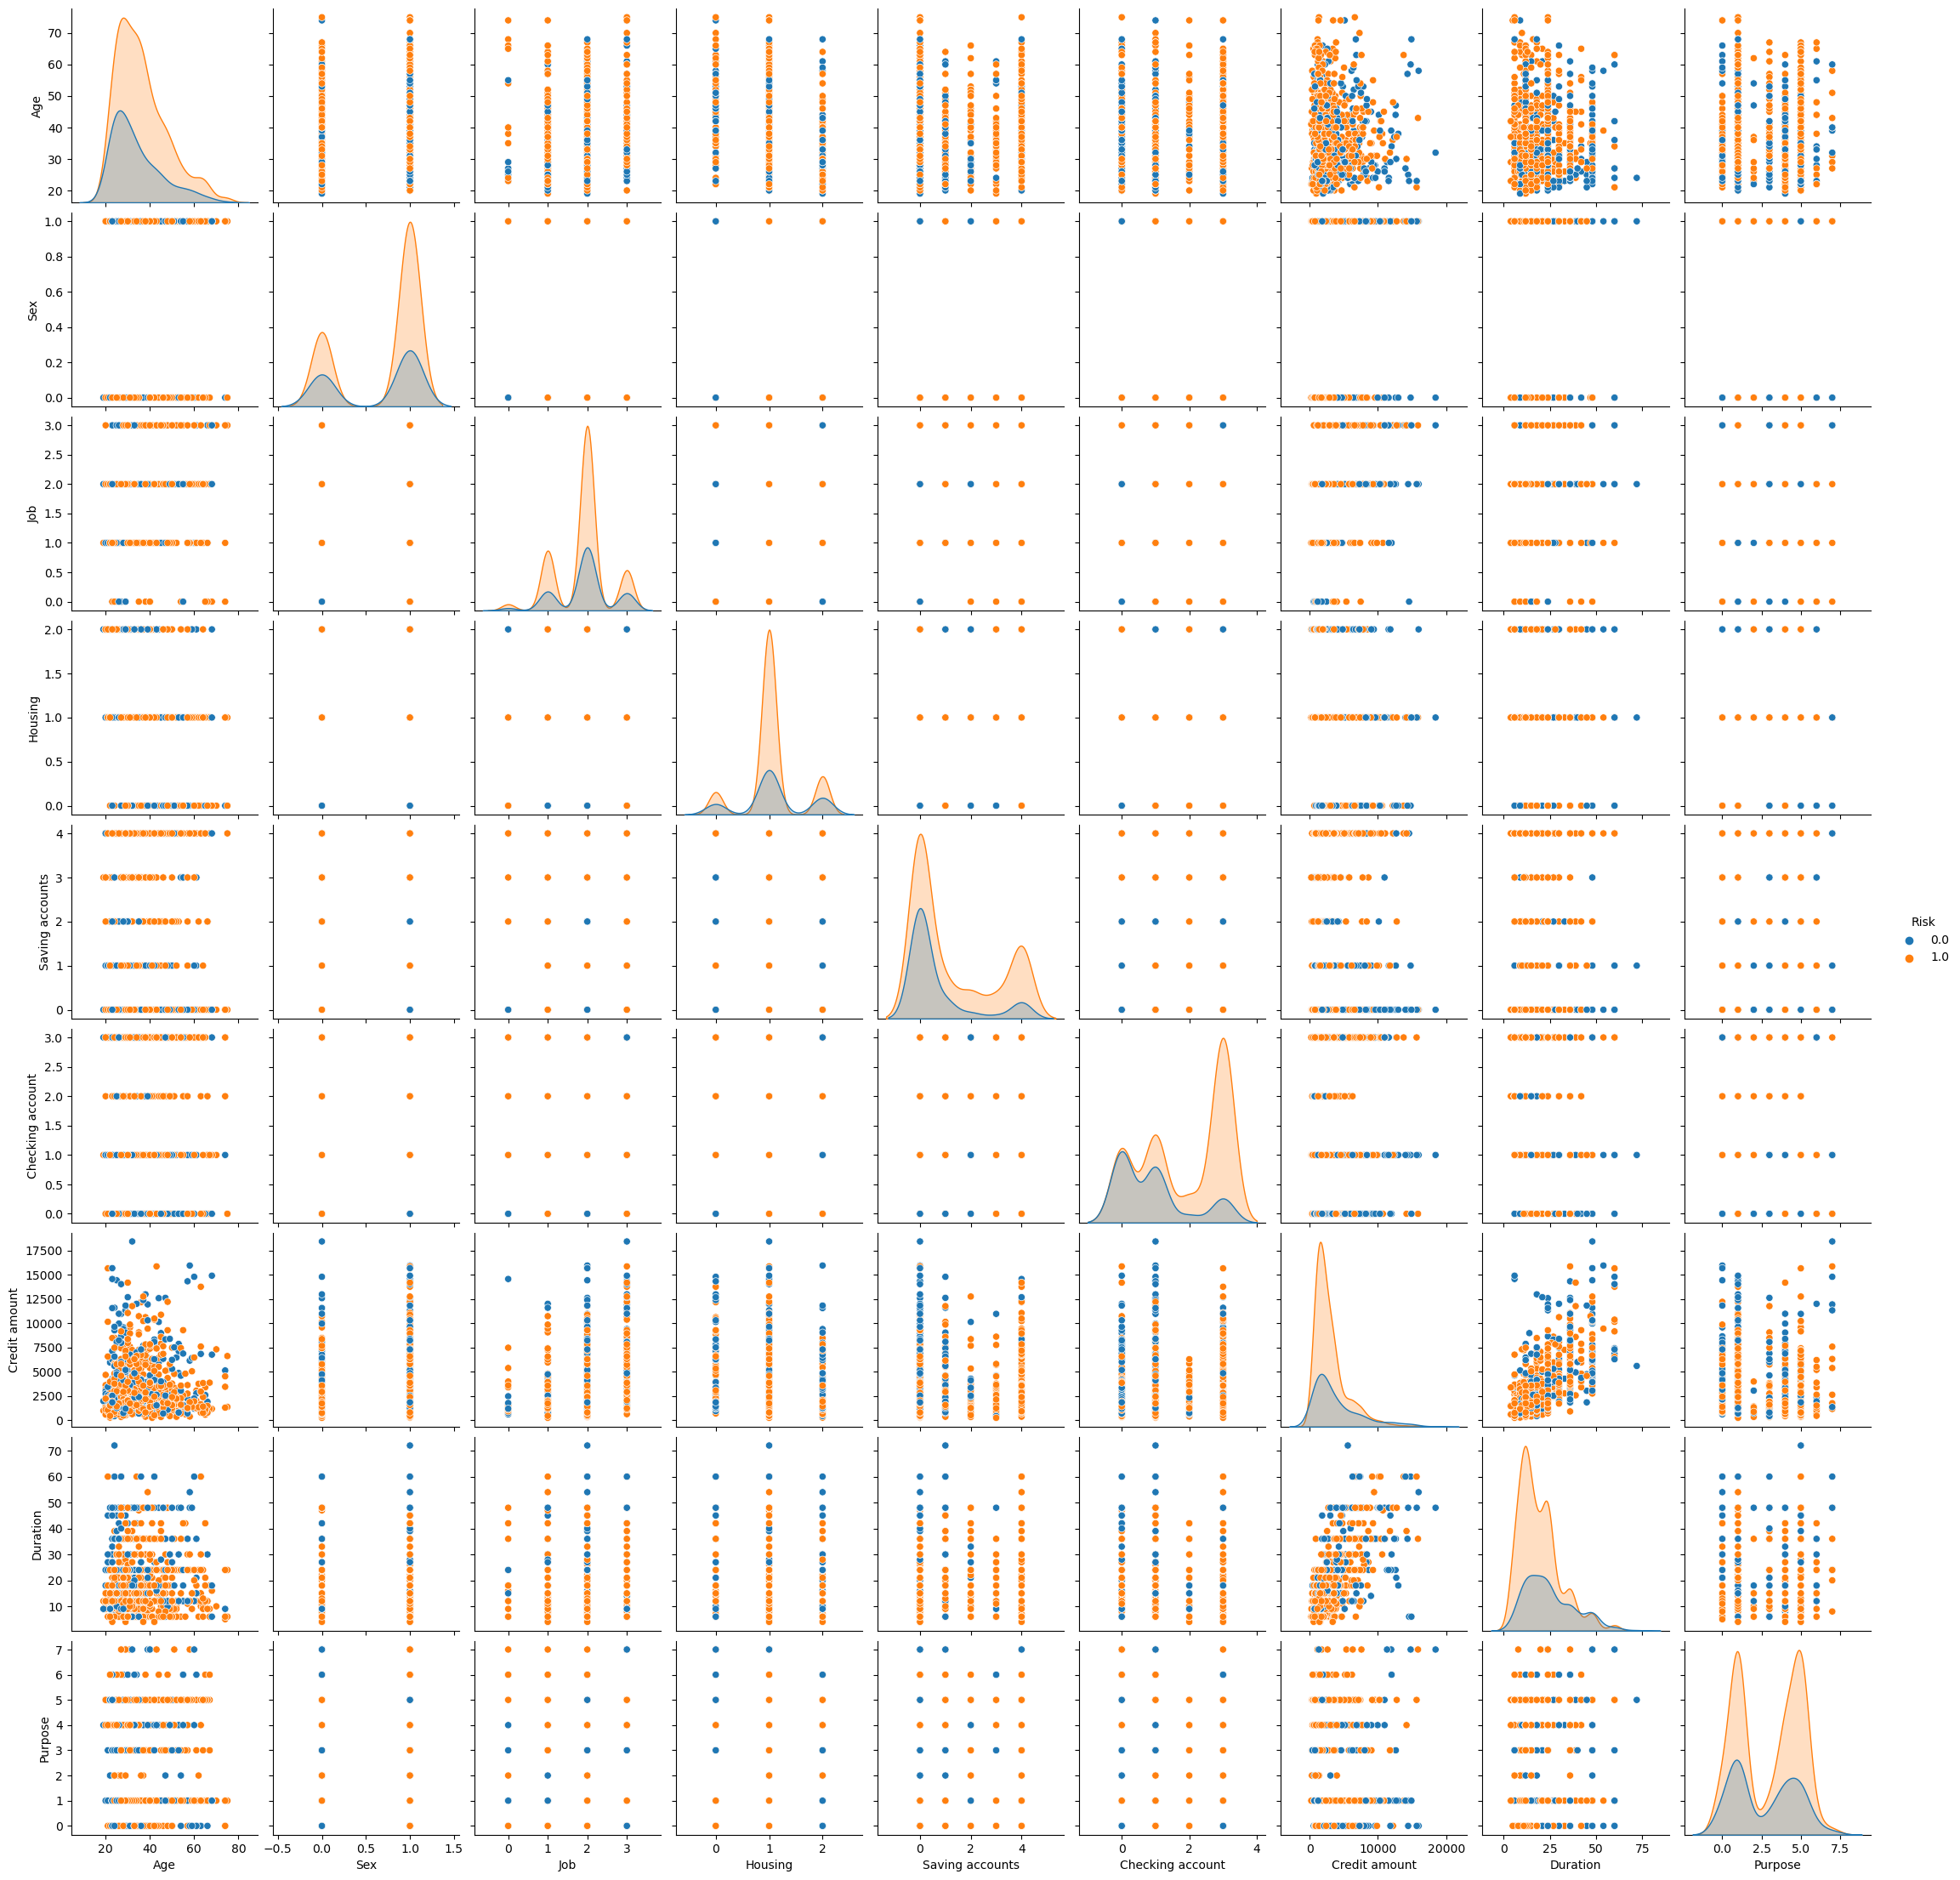

In [56]:
sns.pairplot(df, hue='Risk')
plt.show()

Целевая переменная распределена не равномерно, больше клиентов с Risk=Good. Из предварительного анализа можно заметить, что чаще всего не отдают кредиты люди, у которых мало средств на счету, что логично. Женщины отдают лучше мужчин. А люди с собственным жильем лучше остальных категорий.

# Задание 2

Разделите датасет на обучающую и тестовую выборки в пропорции 80:20. Разделение должно быть стратифицированным по таргету Risk.

В этом и следующих заданиях используйте random_state = 1.

In [82]:
df_train, df_test = train_test_split(df, stratify=df['Risk'], test_size=0.2, random_state=1)

# Задание 3

Проведите этап очистки и подготовки данных (data preparation) и подготовьте данные к моделированию.

Выполнено в п.1

# Задание 4

Сбалансируйте обучающую выборку методом SMOTE и обучите модель RandomForestClassifier. Подберите оптимальные гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [89]:
os = SMOTE(random_state=1, k_neighbors=2)

features = df_train.drop(columns=['Risk']).columns
target = 'Risk'

X_train, y_train = os.fit_resample(df_train[features], df_train[target])

In [90]:
model = RandomForestClassifier( random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [98]:
# Подберем параметры модели
parametrs = { 'n_estimators': range(3,10,1),
            'max_depth' : range(3,10,1)}
grid = GridSearchCV(model, parametrs, cv=3, scoring = 'roc_auc')
grid.fit(X_train, y_train)
print(f'Лучшие параметры градиентонго спуска:\n {grid.best_params_}')
print(f'Значение roc_auc : {grid.best_score_}')

Лучшие параметры градиентонго спуска:
 {'max_depth': 9, 'n_estimators': 9}
Значение roc_auc : 0.8643654784457837


In [94]:
# Обучим модель с лучшими параметрами 
model = RandomForestClassifier(n_estimators=9, max_depth=9,  random_state=1)
model.fit(X_train, y_train)
roc_auc = roc_auc_score(df_test['Risk'], model.predict_proba(df_test.drop(columns=['Risk']))[:, 1])
print(f'Значение roc_auc: {roc_auc}')

Значение roc_auc: 0.7452380952380951


# Задание 5

Обучите модель RandomForestClassifier с использованием весов классов. Подберите оптимальные веса и гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [101]:
X_train, y_train = df_train[features], df_train[target]
model = RandomForestClassifier( random_state=1)
model.fit(X_train, y_train)
# Подберем параметры модели
parametrs = { 'n_estimators': range(3,10,1),
            'max_depth' : range(3,10,1),
            'class_weight': ['balanced', 'balanced_subsample',{0: 1000, 1: 1}]
            }
grid = GridSearchCV(model, parametrs, cv=3, scoring = 'roc_auc')
grid.fit(X_train, y_train)
print(f'Лучшие параметры градиентонго спуска:\n {grid.best_params_}')
print(f'Значение roc_auc : {grid.best_score_}')

Лучшие параметры градиентонго спуска:
 {'class_weight': 'balanced_subsample', 'max_depth': 8, 'n_estimators': 9}
Значение roc_auc : 0.7356274437927665


In [102]:
# Обучим модель с лучшими параметрами 
model = RandomForestClassifier(n_estimators=9, max_depth=8,  random_state=1, class_weight='balanced_subsample')
model.fit(X_train, y_train)
roc_auc = roc_auc_score(df_test['Risk'], model.predict_proba(df_test.drop(columns=['Risk']))[:, 1])
print(f'Значение roc_auc: {roc_auc}')

Значение roc_auc: 0.7898214285714286


Балансировка слассов в модели дала результат лучше, чем метод SMOTE.